# Lesson 1: Getting Started

In this mini-project I'll be tuning an existing model to classify images, and learning some of the basic building blocks of fastai. Much like in the lesson, I'll be creating my own dataset via images sourced from DuckDuckGo, normalzing and splitting the data, and then fine tuning an existing model to fit my speific classification problem.

In [7]:

# We'll use this DuckDuckGo package to search for and get the url of images
from duckduckgo_search import ddg_images

# Once we have image URLs, we'll use fastdownload to download the images so we can access them locally
from fastdownload import download_url

# And since this is a fast.ai course, we'll of course be making heavy use of the fast.ai library
from fastcore.all import *
from fastai.vision.all import *



We'll need to decide what we'd like to classify with this model. I think it'd be interesting to try to classify the make of a car, so we'll try to differentiate between a few different brands.

I'll consider cars from the brands Ford (USA), Honda (Japan), Porsche (Germany), and Maserati (Italy). in order to diversify across manufacturors from 4 different countries. In order to make sure I have a wide range of cars from each manufacturer, I'll search for years spanning from 2010-2022.

In [84]:
years = [y for y in range(2010, 2023)]
brands = ['Honda', 'Ford', 'Porsche', 'Maserati']

Now let's grab the images! First let's make sure our plan for search terms yields good results. I actually had some access/corruption issues for images from older years and various websites, so I decided to tack on "kbb.com" (a populat car database site) to my search query, which really seemed to help mitigate that problem.

In [85]:
import ipyplot

# we'll use this helper function from the lesson to search for and retrieve urls for images
def search_images(term, max_images=30):
    return L(ddg_images(term, max_results=max_images)).itemgot('image')


urls = search_images('2010 Porsche "kbb.com"', max_images=10)
ipyplot.plot_images(urls, max_images=10, img_width=200)
    

These images look great, now we can fetch the entire dataset.

In [87]:
from time import sleep
path = Path('car_brands')

for brand in brands:
    p = path/brand
    dest = (p)
    dest.mkdir(parents=True, exist_ok=True)
    for year in years:
        download_images(dest, urls=search_images(f'{year} {brand} "kbb.com"'), max_pics=50)
        sleep(10)
    resize_images(p, max_size=800, dest=p)
        

Next, we'll check for any images that downloaded incorrectly and remove them.

In [88]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)

(#79) [None,None,None,None,None,None,None,None,None,None...]

Now we use a fastai DataLoader to create a training & validation set with the images we downloaded. Sometimes the features that differentiate cars are quite small so I've chosen to keep the image resolution a bit larger than the example in class. My hypothesis is this will result in better accuracy.

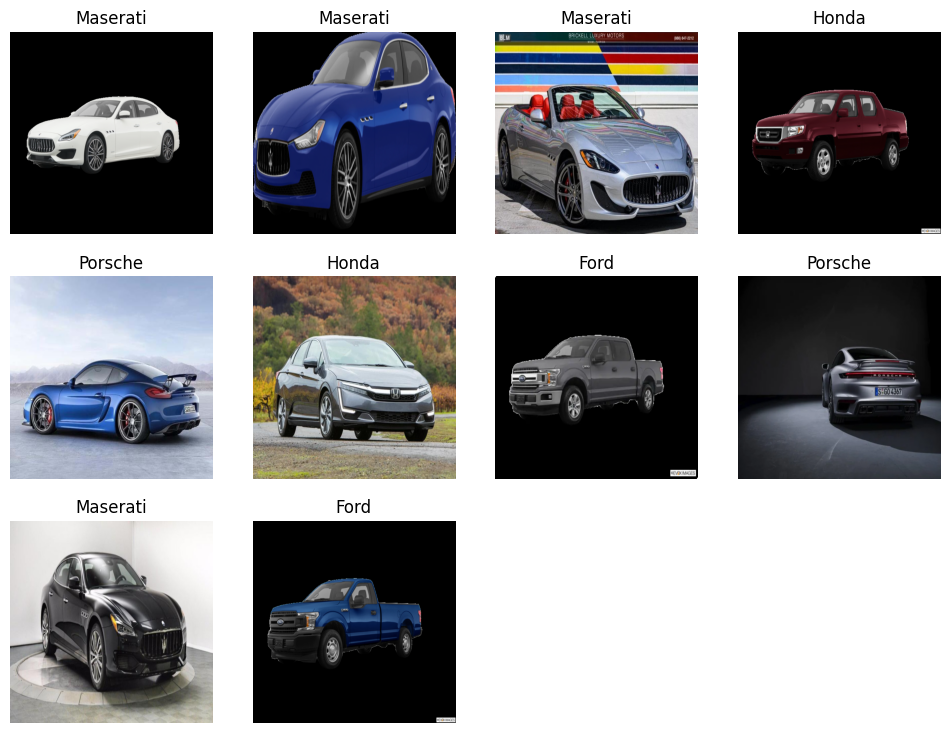

In [89]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=78),
    get_y=parent_label,
    item_tfms=[Resize(800, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=10)

Next, we'll load the model and train it! Setting this all up by hand can be cumbersome so it's nice that fastai allows us to do all this in 2 lines of code!

In [90]:
learn = vision_learner(dls, 'resnet18', metrics=error_rate)
learn.fine_tune(5)

epoch,train_loss,valid_loss,error_rate,time
0,1.410020,0.652804,0.222997,14:32


epoch,train_loss,valid_loss,error_rate,time
0,0.569307,0.464332,0.174216,20:08
1,0.451880,0.444816,0.153310,20:26
2,0.327481,0.298059,0.094077,19:00
3,0.220712,0.274411,0.101045,19:05
4,0.160446,0.279191,0.090592,20:07


This ran fairly slowly on my MacBook Air, but it will go much faster on a GPU! If you are training a similar project on a CPU, I hope you have other things to get done today :) An error rate of 9%, while not as accurate as the model trained in class, is still pretty good! To a human eye this is a significantly harder problem, so it's cool to see resnet18 still perform well!

Let's try pulling in some 2023 models and see how our classifier does on out-of-sample data.

In [118]:
from PIL import Image

brands.sort()

images = []
for brand in brands:
    url = search_images(f'2023 {brand} "kbb.com"', max_images=1)[0]
    dest = f'2023_{brand}.jpg'
    download_url(url, dest, show_progress=False)
    images.append(dest)






Predicted: Ford, actual: Ford.
Probability it's a Ford: 0.9993


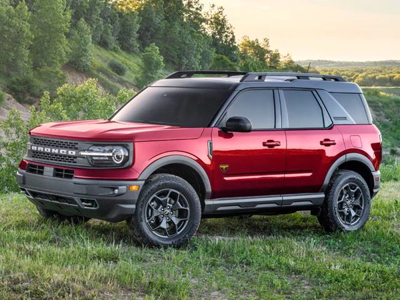

In [119]:
pred_class,_,probs = learn.predict(PILImage.create(images[0]))
print(f"Predicted: {pred_class}, actual: {brands[0]}.")
print(f"Probability it's a {brands[0]}: {probs[0]:.4f}")
Image.open(images[0]).to_thumb(400,400)

Predicted: Honda, actual: Honda.
Probability it's a Honda: 0.9998


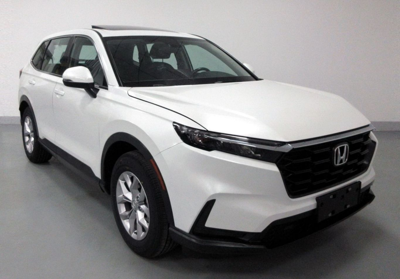

In [120]:
pred_class,_,probs = learn.predict(PILImage.create(images[1]))
print(f"Predicted: {pred_class}, actual: {brands[1]}.")
print(f"Probability it's a {brands[1]}: {probs[1]:.4f}")
Image.open(images[1]).to_thumb(400,400)

Predicted: Maserati, actual: Maserati.
Probability it's a Maserati: 0.9996


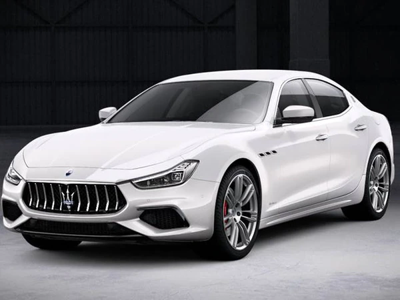

In [121]:
pred_class,_,probs = learn.predict(PILImage.create(images[2]))
print(f"Predicted: {pred_class}, actual: {brands[2]}.")
print(f"Probability it's a {brands[2]}: {probs[2]:.4f}")
Image.open(images[2]).to_thumb(400,400)

Predicted: Honda, actual: Porsche.
Probability it's a Porsche: 0.0731


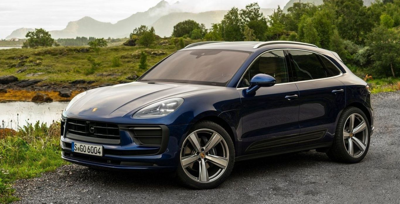

In [122]:
pred_class,_,probs = learn.predict(PILImage.create(images[3]))
print(f"Predicted: {pred_class}, actual: {brands[3]}.")
print(f"Probability it's a {brands[3]}: {probs[3]:.4f}")
Image.open(images[3]).to_thumb(400,400)

3 for 4 is not a bad start! In future lessons we'll learn how to further tune the model.